In [1]:
import skimage
from skimage import io
import numpy as np
from PIL import Image
from PIL import ImageDraw
from transformers import pipeline
import easyocr
from sklearn.cluster import DBSCAN

C:\Users\bt0401\anaconda3\envs\ML\lib\site-packages\transformers\utils\generic.py:462: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\bt0401\anaconda3\envs\ML\lib\site-packages\transformers\utils\generic.py:319: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\bt0401\anaconda3\envs\ML\lib\site-packages\transformers\utils\generic.py:319: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\bt0401\anaconda3\envs\ML\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Die angegebene Prozedur wurde nicht gefunden'If you don't plan on using image fun

# Summary
For image detection, we do the following
1. Try to find the error message within an image
2. Find all texts in the image
3. Filter the texts. Only the texts in the error message are relevant. All other texts, we do not care about.

## Step 1: Object recognition: Find error message 

In [4]:
from transformers import pipeline
# load model for object detection
checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection") #, device='python'

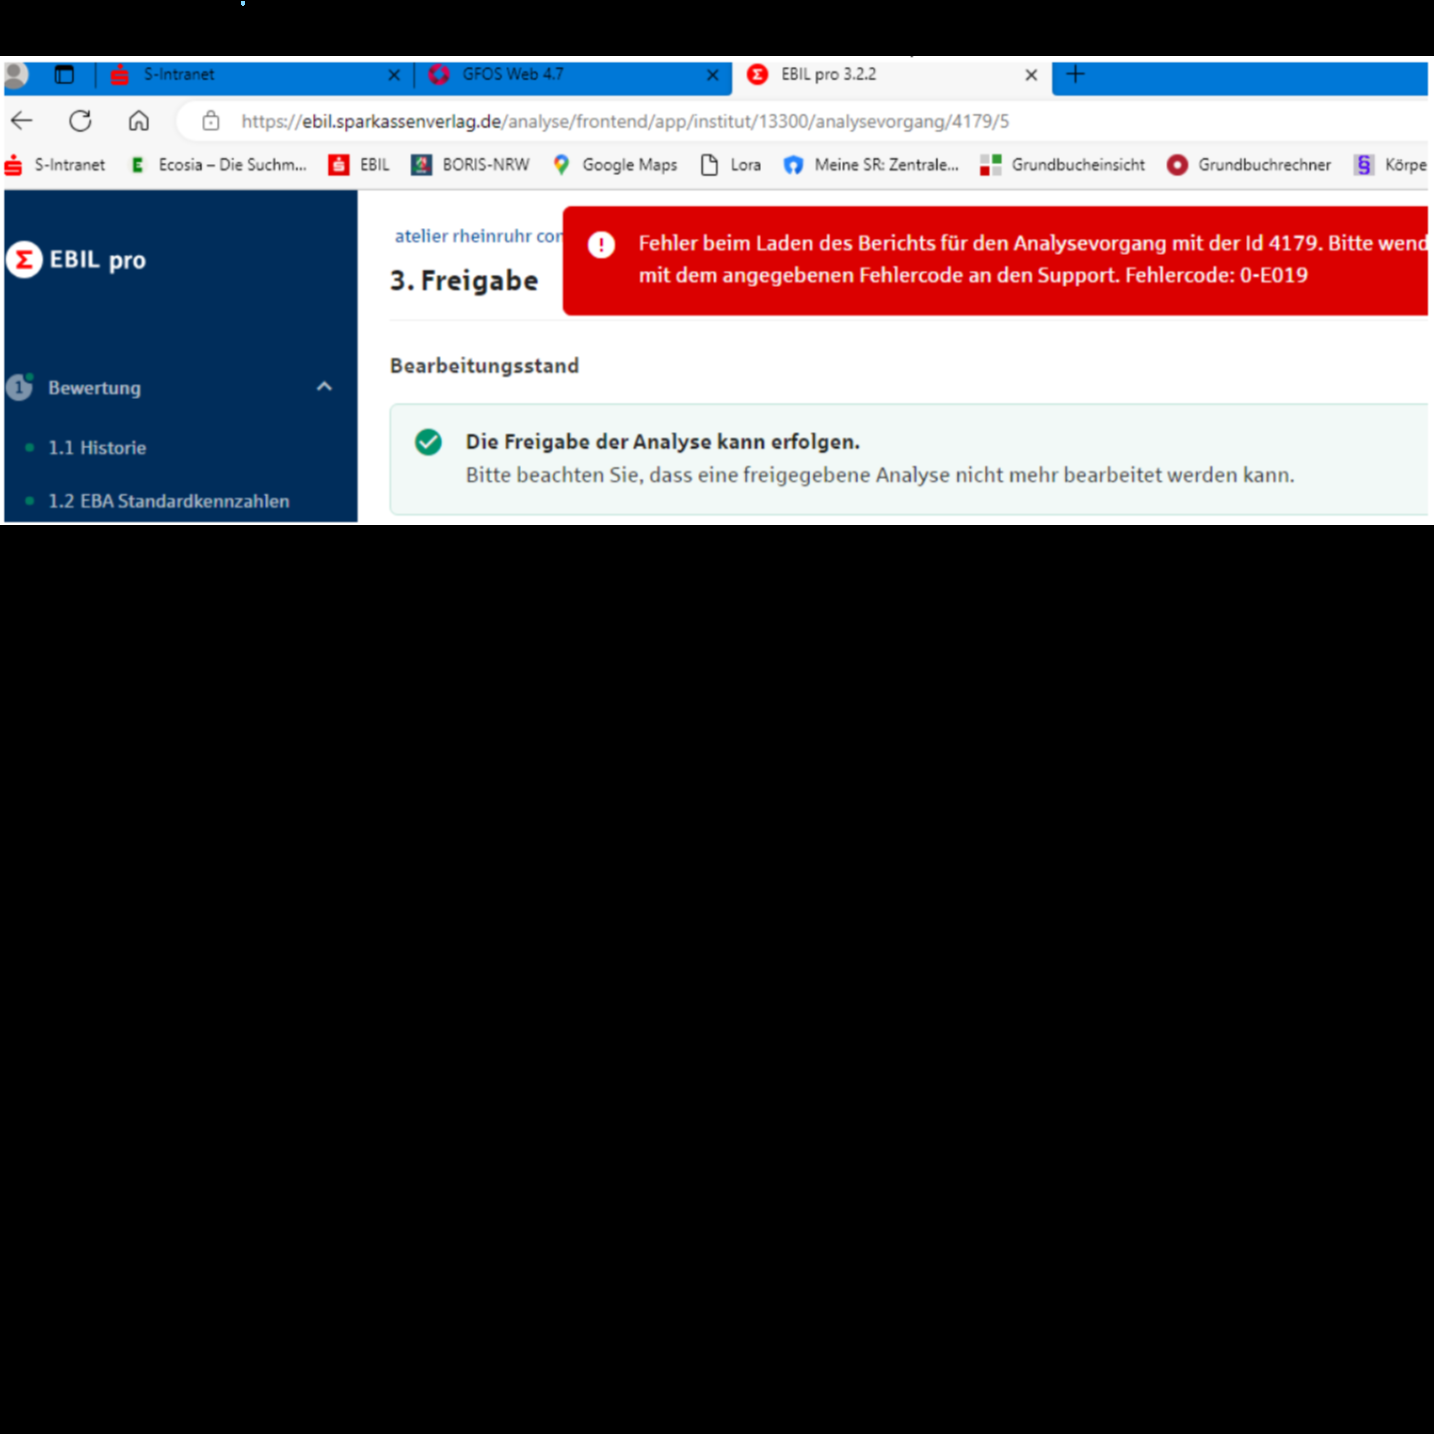

In [5]:
#img_path ='microsoft.png' # the image (in the current directory) which we want to perform object detection on
#img_path='gemein.png'
#img_path='login.png'
img_path='Bild_klein.png'

# read image as numpy array
def read_img_np():
    testimg = io.imread(img_path)
    # remove opacity
    img = testimg[:, :, :-1]
    # create padded image (because we need our image to be quadratic for the ai tools to work)
    dims = img.shape
    max_dim = max(dims[0], dims[1])
    padded_img = np.zeros((max_dim, max_dim, 3))
    padded_img[:img.shape[0], :img.shape[1], :img.shape[2]] = img
    # return as np array
    return np.uint8(padded_img)

# read the image as Image object
def read_img():
    return Image.fromarray(read_img_np()).convert("RGB")

# print the image
read_img()


In [6]:
# search for specific things in the image
predictions = detector(
    read_img(),
    hypothesis_template="The screenshot shows {}", # similar to "system" prompt in text generation tasks 
    candidate_labels=["red error message", "warning", "problem", "exception", "fault" ], # the is what we are looking for. (purple elefant should not be found)
)
scores = [pred['score'] for pred in predictions]
print(scores)
predictions

[0.5210772752761841, 0.21840068697929382, 0.21463453769683838, 0.18351486325263977, 0.1602078676223755, 0.15433678030967712, 0.15027257800102234, 0.1390422135591507, 0.13541920483112335, 0.12465091794729233, 0.12041909247636795, 0.1197979599237442, 0.11922407895326614, 0.11232366412878036, 0.10945422947406769, 0.10645540803670883, 0.10447105765342712]


[{'score': 0.5210772752761841,
  'label': 'red error message',
  'box': {'xmin': 554, 'ymin': 207, 'xmax': 1436, 'ymax': 317}},
 {'score': 0.21840068697929382,
  'label': 'problem',
  'box': {'xmin': 7, 'ymin': 53, 'xmax': 1429, 'ymax': 526}},
 {'score': 0.21463453769683838,
  'label': 'exception',
  'box': {'xmin': 15, 'ymin': 135, 'xmax': 1433, 'ymax': 191}},
 {'score': 0.18351486325263977,
  'label': 'exception',
  'box': {'xmin': 7, 'ymin': 53, 'xmax': 1429, 'ymax': 526}},
 {'score': 0.1602078676223755,
  'label': 'problem',
  'box': {'xmin': 15, 'ymin': 135, 'xmax': 1433, 'ymax': 191}},
 {'score': 0.15433678030967712,
  'label': 'red error message',
  'box': {'xmin': 15, 'ymin': 135, 'xmax': 1433, 'ymax': 191}},
 {'score': 0.15027257800102234,
  'label': 'exception',
  'box': {'xmin': 391, 'ymin': 402, 'xmax': 1428, 'ymax': 519}},
 {'score': 0.1390422135591507,
  'label': 'problem',
  'box': {'xmin': 391, 'ymin': 402, 'xmax': 1428, 'ymax': 519}},
 {'score': 0.13541920483112335,
  

In [7]:
# Using k-means clustering for determining which of the results are the best.
# We use k-means clustering because:
# - we do not know the distribution of our prediction values beforehand (we cannot assume normal distribution for example)
# - we do not know the number of predicitons beforehand
# - we know the number of our clusters k, because presumably, there are 2 groups of predictions: good predictions and bad predictions. Therefore, k=2.


scores_shaped = np.array(scores).reshape(-1, 1)  # reshape for the clustering
# min_samples=1 indicates that a cluster can consist of at least 1 element (score).
# eps=0.05 is the maximum distance between two scores for them to be considered as in the same neighborhood
dbscan = DBSCAN(eps = 0.05, min_samples = 1)
clusters = dbscan.fit_predict(scores_shaped)

# get best scores
highest_cluster = clusters.min()
best_scores = scores_shaped[clusters == highest_cluster]

print(best_scores)

[[0.52107728]]


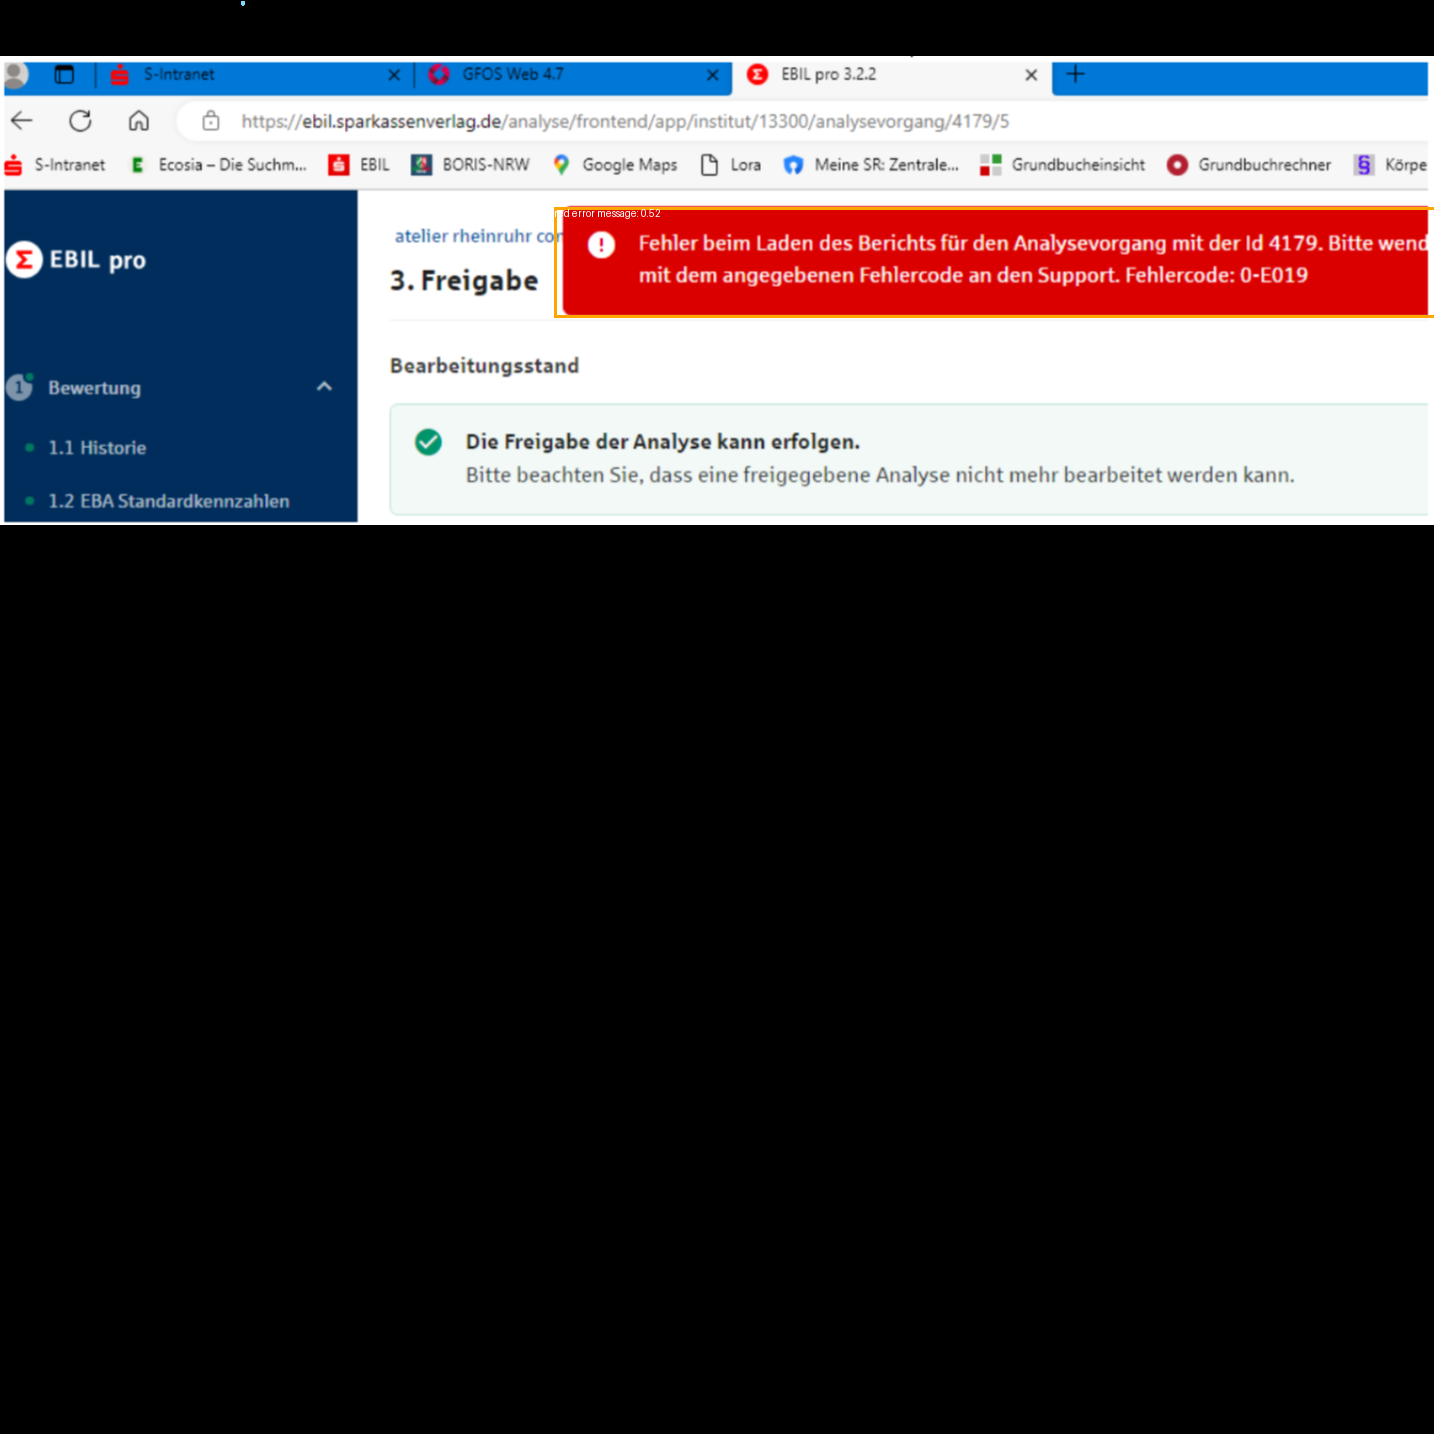

In [8]:
# visualize the predictions in the image
overlay_img = read_img()
draw = ImageDraw.Draw(overlay_img)

def get_bounding_box_for_prediction(n): 
    box = predictions[n]["box"]
    return box.values()


for prediction in predictions[:len(best_scores)]:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]
    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="orange", width=3)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

overlay_img

## Step 2: Text classification: Find all texts in image

In [9]:
# Load the text classification model
classifier = pipeline(model='facebook/bart-large-mnli', task='zero-shot-classification') # TODO decide for a good model. Default is facebook/bart-large-mnli

# Load the screenshot image and extract all text elements using OCR
reader = easyocr.Reader(['de'])
results = reader.readtext(read_img_np())
print(results)

C:\Users\bt0401\anaconda3\envs\ML\lib\site-packages\transformers\utils\generic.py:319: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[143, 65], [219, 65], [219, 83], [143, 83]], 'S-Intranet', 0.859730909540416), ([[461, 63], [565, 63], [565, 83], [461, 83]], 'GFOS Web 4.7', 0.7201853883879847), ([[778, 62], [880, 62], [880, 88], [778, 88]], 'EBIL Pro 3.22', 0.5731930017796463), ([[238, 108], [1014, 108], [1014, 136], [238, 136]], 'https: / /ebil sparkassenverlag delanalyse/frontend/applinstitut/13300/analysevorgang/4179/5', 0.7207788333641021), ([[30, 152], [110, 152], [110, 176], [30, 176]], 'S-Intranet', 0.463040111501257), ([[159, 157], [205, 157], [205, 175], [159, 175]], 'Ecosia', 0.998881784050482), ([[214, 152], [310, 152], [310, 176], [214, 176]], 'Die Suchm .', 0.4490286716215246), ([[356, 152], [392, 152], [392, 176], [356, 176]], 'EBIl', 0.2561371624469757), ([[438, 152], [534, 152], [534, 176], [438, 176]], 'BORIS-NRW', 0.6298282144873131), ([[578, 154], [682, 154], [682, 178], [578, 178]], 'Google Maps', 0.9783690910003793), ([[727, 155], [763, 155], [763, 175], [727, 175]], 'Lora', 0.998704969882965

## Step 3: Only keep texts that are within predicted error message

In [ ]:
matches = [] # filter for duplicates by remembering all already found text bounding boxes
predicted_texts = []
for text_result in results:
    for idx, prediction in enumerate(predictions[:len(best_scores)]):
        score = prediction["score"]
        xmin, ymin, xmax, ymax = get_bounding_box_for_prediction(idx)
        (tl, tr, br, bl) = text_result[0]
        # convert to integer
        tl = (int(tl[0]), int(tl[1]))
        tr = (int(tr[0]), int(tr[1]))
        br = (int(br[0]), int(br[1]))
        bl = (int(bl[0]), int(bl[1]))
        # get middle of each textbox
        middle_of_box_x = (int(bl[0]) + ((int(br[0]) - int(bl[0])) / 2))
        middle_of_box_y = (int(bl[1]) + ((int(tl[1]) - int(bl[1])) / 2))
        middle_of_box = (middle_of_box_x, middle_of_box_y)
        # check if textbox is within prediction
        point_in_bounds = ((middle_of_box[0] >= xmin and middle_of_box[0] <= xmax) and (middle_of_box[1] >= ymin and middle_of_box[1] <= ymax))
        if point_in_bounds:
            if text_result[0] not in matches: 
                predicted_texts.append(text_result)
                matches.append(text_result[0])

In [ ]:
# visualize both predictions and texts
overlay_img = read_img()
draw = ImageDraw.Draw(overlay_img)

def get_bounding_box_for_prediction(n): 
    box = predictions[n]["box"]
    return box.values()


for prediction in predictions[:len(best_scores)]:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]
    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="orange", width=3)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

for predicted_text in predicted_texts:
    box = predicted_text[0]
    score = prediction["score"]
    xmin = box[0][0]
    xmax = box[2][0]
    ymin = box[0][1]
    ymax = box[2][1]
    draw.rectangle((xmin, ymin, xmax, ymax), outline="green", width=2)

overlay_img

In [ ]:
# the final result:
joined = ' '.join([predicted_text[1] for predicted_text in predicted_texts])
print(joined)